<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from micdrop.src.preprocessing.run_preprocessing import run_preprocessing, load_raw_data
from micdrop.src.model.train_evaluate_model import run_fit_evaluate_model
from micdrop.utils.evaluate_model import calc_chi_2_test
from micdrop.run import pre_run_checks
from micdrop.utils.plotting_helpers import plot_subscription_rate_by_var, plot_partial_dependence
base_folder = pre_run_checks("preprocessing")

# Exploratory data analysis

The primary goal of this analysis is to increase subscription rate: #subscribers / total clicks

In [3]:
df = load_raw_data(f"{base_folder}/data/raw/micdrop_subsciptions_data_v1.csv").fillna("Unknown")
df_clean = pd.read_parquet(f"{base_folder}/data/processed/cleaned.parquet")

Reading data from: C:/Users/Furton Akos/Desktop/stackoverflow_auto_mod/data/raw/micdrop_subsciptions_data_v1.csv


In [4]:
df.head()

,click_date,platform,customer_city,customer_state,urban_flag,credit_card_on_file,student,fav_genre,subscriber
0,2017-12-27,mobile web,san antonio,tx,1,0,0,hip_hop,True
1,2018-01-10,mobile web,honolulu,hi,0,0,0,hip_hop,False
2,2017-12-15,desktop web,atlanta,ga,1,0,0,hip_hop,True
3,2018-01-06,mobile web,honolulu,hi,0,0,0,hip_hop,False
4,2017-12-20,mobile web,miami,fl,0,0,0,indie_rock,False


In [5]:
print(f"The base rate of conversion is {round(df['subscriber'].mean() * 100, 2)}%.")

The base rate of conversion is 7.21%.


First, inspect the data to identify any clear outliers. Use the describe function for continuous/binary variables and groupby/count for categorical values

Notably, there are no continuous variables in the dataset, only binary and categorical variables

## Binary Variables

A few observations:
* The advertising campaign is split equally between urban / non-urban. However, we don't know if non-urban refers to suburban or rural.
* A small percentage of clicks (~2%) already have a credit card on file; these are likely existing users of MicDrop
* A sizable minority of clicks (~30%) come from students. These users are likely trend younger than the non-students

In [6]:
df.describe()

,urban_flag,credit_card_on_file,student
count,94194.000000,94194.000000,94194.000000
mean,0.506911,0.021604,0.300093
std,0.499955,0.145389,0.458301
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


## Categorical Variables

A few observations:

### Click Date
* The ad campaign ran for approx. 1 month from mid-December 2017 to mid-January 2018. This period includes the holiday period of Christmas and New Years, which may skew results. User behavior may be considerably different in holiday vs non-holiday periods especially for students (~30% of the click population)
* The ad campaign received the most clicks in its first week (~3.5k daily), had a sharp drop in clicks for both Christmas and New Years, and then recovers to 2.5 - 3k clicks per day in January.

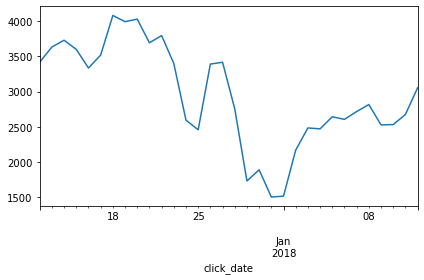

In [7]:
df.groupby("click_date").size().plot();

### Platform
* Approximately 70% of clicks occur from a mobile device, the remainder from desktop. There are a few unknown values which are kept because they will not materially affect any modeling.

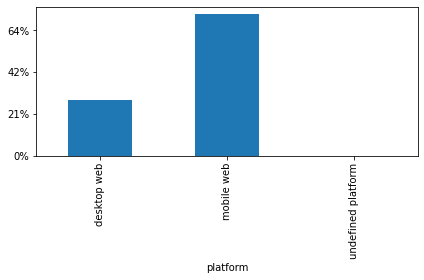

In [8]:
import matplotlib.ticker as mtick

ax = df.groupby("platform").size().plot(kind="bar")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = len(df)));

In [9]:
df_clean.groupby("platform").mean()

,subscriber,city_rank_by_size,cum_pct
platform,,,
desktop web,0.078654,34.584981,0.451379
mobile web,0.069487,42.866233,0.537276
undefined platform,0.000000,455.000000,0.989861


### Customer City
* A small handful of cities are responsible for most clicks. There is a long tail of cities that should be grouped into an "other" category for modeling. 
* The customer city may NOT be representative of the location of the user at the time of the ad click because of increased travel around the holiday season, ESPECIALLY for students.
* The most common cities are "Los Angeles", "Miami", "Honolulu", "Denver", and "Las Vegas". This may indicate that the ad-campaign targeted a number of large metro areas.
* NOTE: It would be helpful to have a "metro area" field to consolidate cities and their suburbs (ex: Tampa vs St. Petersburg, Miami vs North Miami)
* NOTE: It would also be helpful to have a "ZIP CODE" field to be able to join demographic information onto the dataset (ex: avg income, family size)
* There is also some cleanup needed with Airport Codes (ex: LAX vs Los Angeles) and leading / trailing spaces

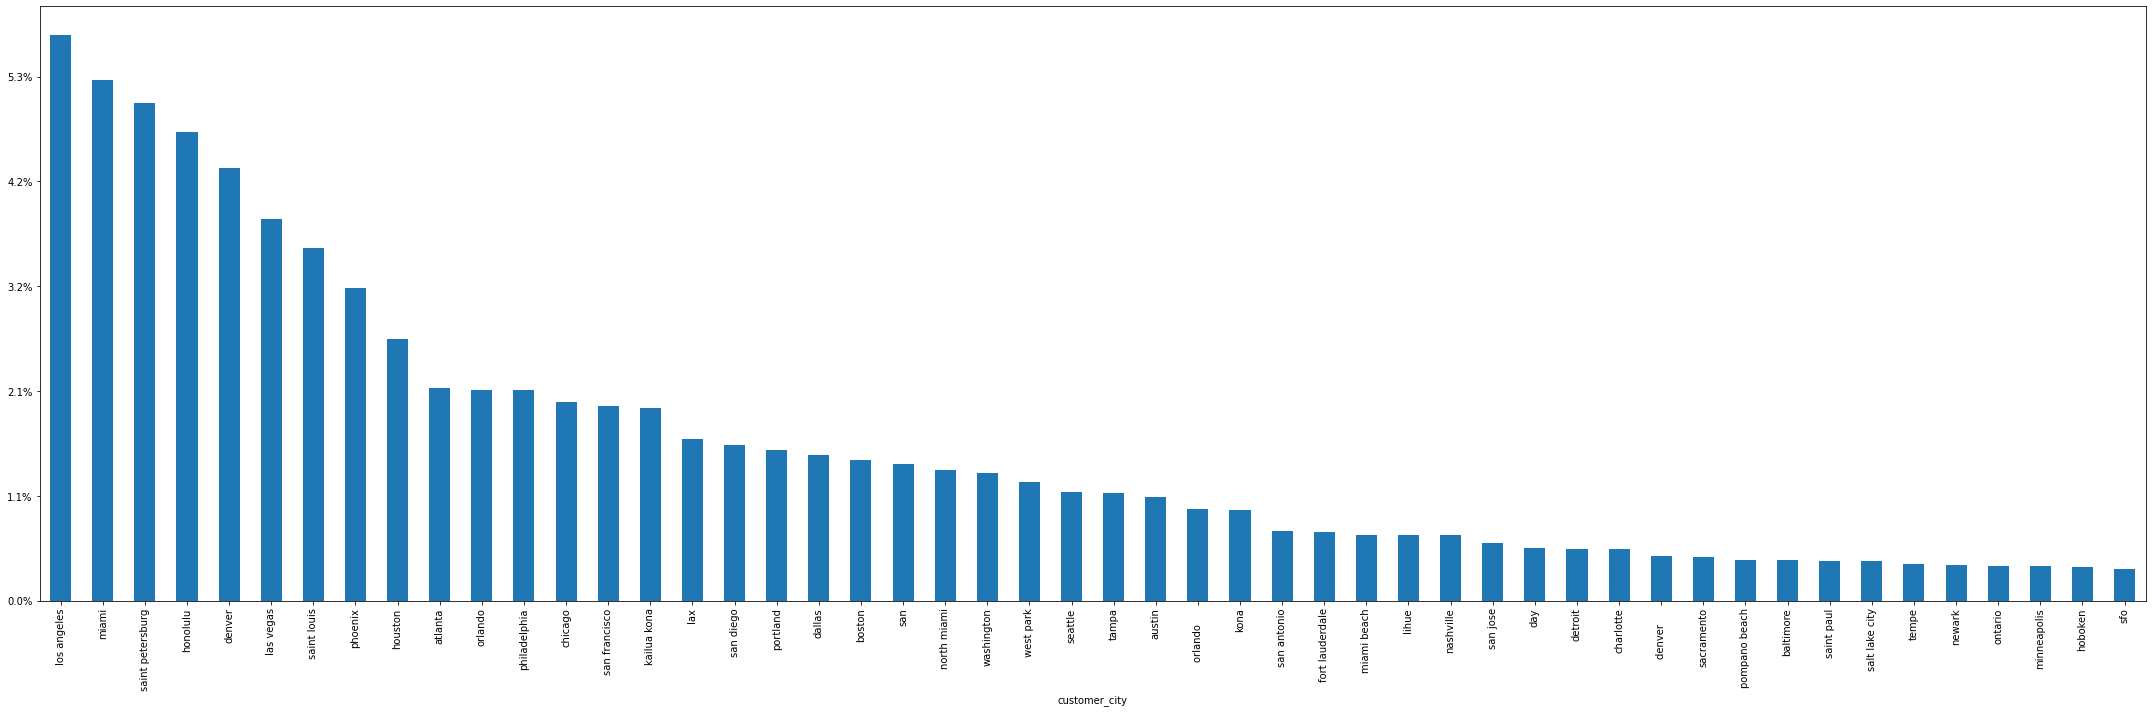

In [10]:
ax = df.groupby("customer_city").size().sort_values(ascending=False)[0:50].plot(kind="bar", figsize=(30, 10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = len(df)));

### Customer State

* Like customer_city, customer state contains a long tail of state values. This is additional data for the hypothesis of: "Customer addresses are less representative of the location of the user (especially students) at the time of the ad click because of increased travel around the holiday season"
* The most common states are "Florida", "California", "Hawaii", "Texas", and "Colorado"
* Hawaii is an interesting choice for the ad-campaign. It is significantly different in demographics to the other large population states.

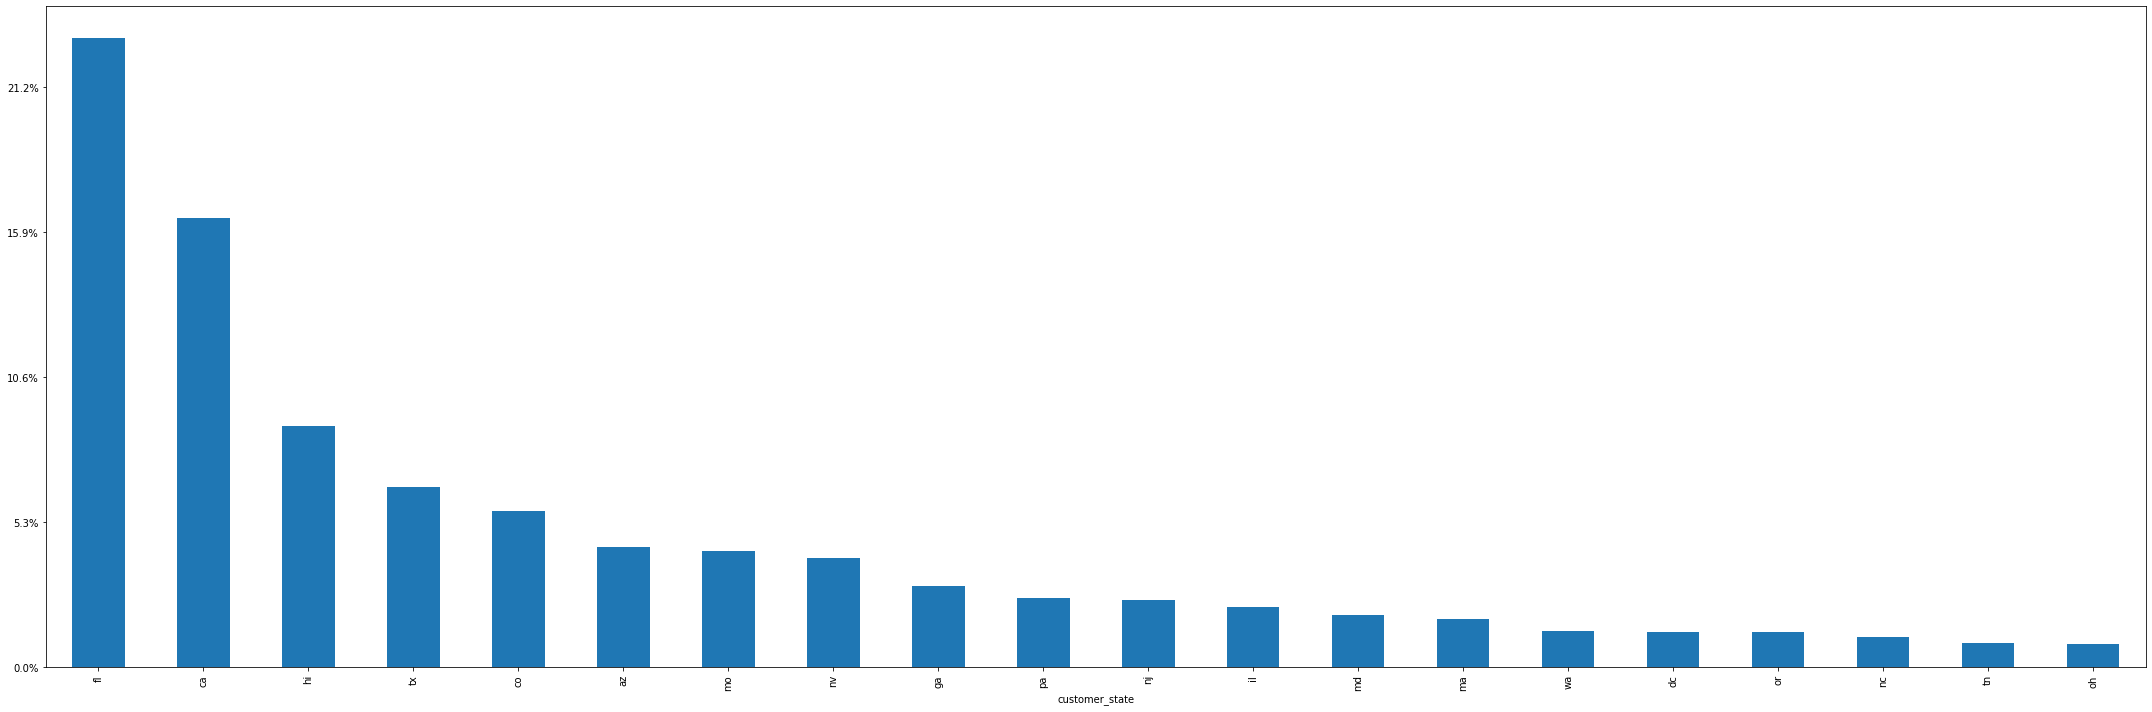

In [11]:
ax = df.groupby("customer_state").size().sort_values(ascending=False)[0:20].plot(kind="bar", figsize=(30, 10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = len(df)));

### Favorite Genre
* The overwhelming majority of clicks come from listeners who enjoy Hip Hop.
* This ad campaign likely targets Hip Hop listeners and encourages them to sign up.
* There are a handful of clicks from users with a missing value for favorite genre.
* Some click are from a set of other genres; these are likely to perform worse because of the mismatch between ad-content and favorite genre

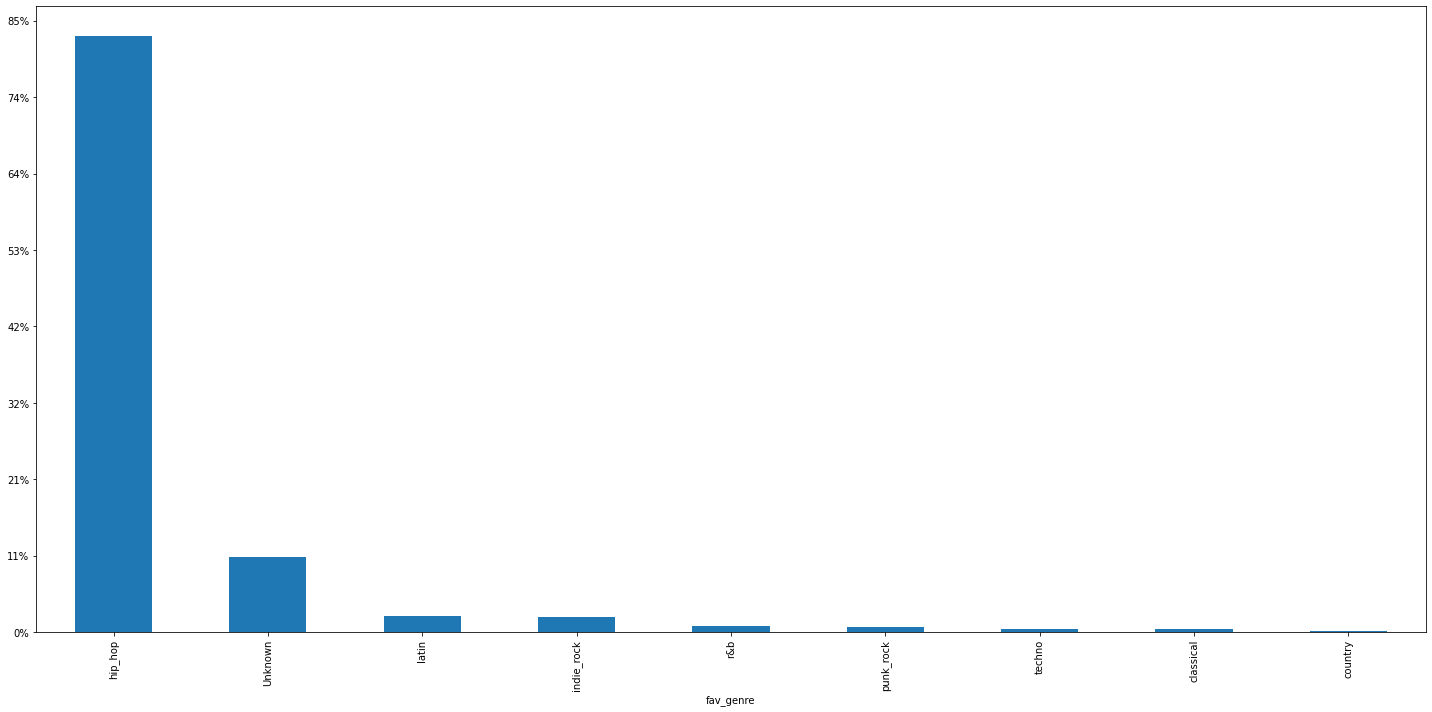

In [12]:
ax = df.groupby("fav_genre").size().sort_values(ascending=False)[0:20].plot(kind="bar", figsize=(20, 10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = len(df)));

## Interactions with the Dependent variable

### Platform

* Desktop clicks subscribe at a higher rate than mobile clicks

In [13]:
calc_chi_2_test(df, "platform")

The p-value is 0.0
The result is significant at the 95% confidence level. The variable platform influences subscriber rates


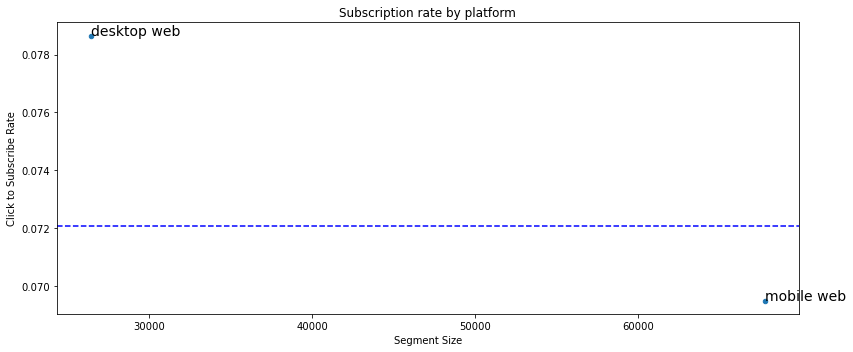

In [14]:
plot_subscription_rate_by_var(df, "platform");

### Customer City

* Certain cities that were targeted perform well (los angeles, honolulu, denver) -> these cities should keep being targeted
* Certain cities with few clicks also performed well (baltimore, philadelphia, atlanta) -> run this ad more in those cities
* Certain cities that were targeted perform much worse than average (st louis, saint petersburg) -> stop running this ad there

In [15]:
df_clean.groupby("city_adj")["subscriber"].count().to_frame().to_csv("tmp2.csv")

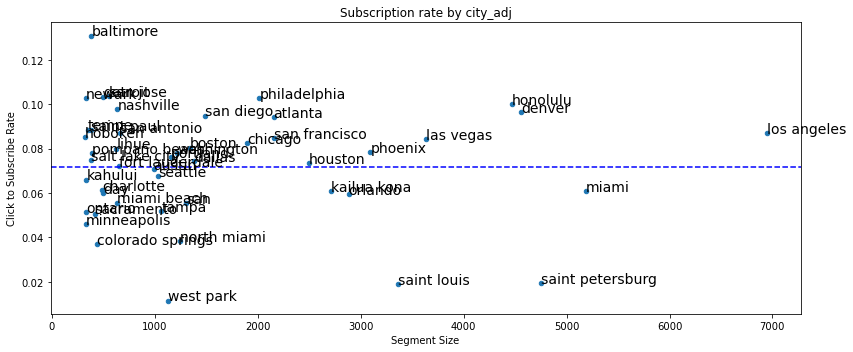

In [16]:
plot_subscription_rate_by_var(df_clean[df_clean["city_adj"]!= "other"], "city_adj")

In [17]:
investigate = df_clean[df_clean["city_adj"] == "saint petersburg"]

In [18]:
df_clean.pivot_table(index = "click_date", columns="city_adj", values="subscriber", aggfunc="count")

city_adj,atlanta,austin,baltimore,boston,charlotte,chicago,colorado springs,dallas,day,denver,...,san,san antonio,san diego,san francisco,san jose,seattle,tampa,tempe,washington,west park
click_date,,,,,,,,,,,,,,,,,,,,,
2017-12-12,78.0,41.0,21.0,60.0,34.0,65.0,13.0,68.0,1.0,189.0,...,34.0,38.0,45.0,97.0,17.0,53.0,65.0,7.0,61.0,17.0
2017-12-13,74.0,48.0,19.0,55.0,47.0,74.0,17.0,72.0,NaN,189.0,...,41.0,37.0,56.0,97.0,20.0,39.0,66.0,9.0,65.0,45.0
2017-12-14,81.0,48.0,34.0,52.0,29.0,78.0,16.0,61.0,NaN,205.0,...,54.0,39.0,67.0,88.0,20.0,43.0,72.0,8.0,60.0,39.0
2017-12-15,93.0,57.0,20.0,41.0,23.0,71.0,11.0,63.0,NaN,184.0,...,76.0,30.0,89.0,92.0,13.0,31.0,57.0,11.0,62.0,52.0
2017-12-16,77.0,45.0,18.0,45.0,27.0,71.0,7.0,60.0,NaN,165.0,...,83.0,20.0,77.0,85.0,16.0,36.0,43.0,21.0,65.0,47.0
2017-12-17,149.0,28.0,30.0,57.0,23.0,85.0,16.0,65.0,NaN,198.0,...,69.0,35.0,71.0,79.0,30.0,12.0,49.0,16.0,53.0,56.0
2017-12-18,140.0,45.0,25.0,57.0,33.0,71.0,14.0,63.0,NaN,202.0,...,88.0,47.0,90.0,103.0,19.0,37.0,70.0,16.0,71.0,43.0
2017-12-19,100.0,50.0,28.0,54.0,27.0,78.0,13.0,52.0,NaN,229.0,...,95.0,29.0,68.0,103.0,22.0,39.0,57.0,15.0,60.0,47.0
2017-12-20,71.0,53.0,23.0,67.0,26.0,94.0,14.0,55.0,1.0,210.0,...,81.0,50.0,86.0,97.0,34.0,52.0,56.0,13.0,82.0,38.0


### Customer State

* Certain states were targeted and perform well (colorado, hawaii, california) -> these states should keep being targeted
* Certain states with few clicks also performed well (south carolina, maryland, georgia) -> run this ad more in those states
* Certain states that were targeted perform below average (florida, missouri) -> stop running the ad in these states

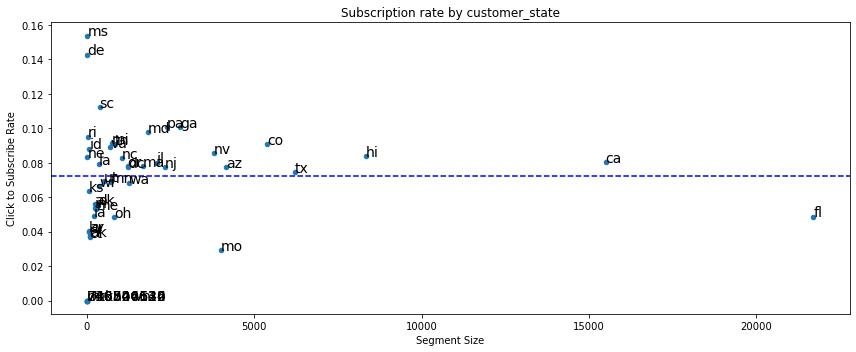

In [19]:
plot_subscription_rate_by_var(df, "customer_state")

### Urban flag
* Urban clicks imploy a higher probability of subscription than non-urban (suburban or rural) clicks

In [20]:
calc_chi_2_test(df, "urban_flag")

The p-value is 0.0
The result is significant at the 95% confidence level. The variable urban_flag influences subscriber rates


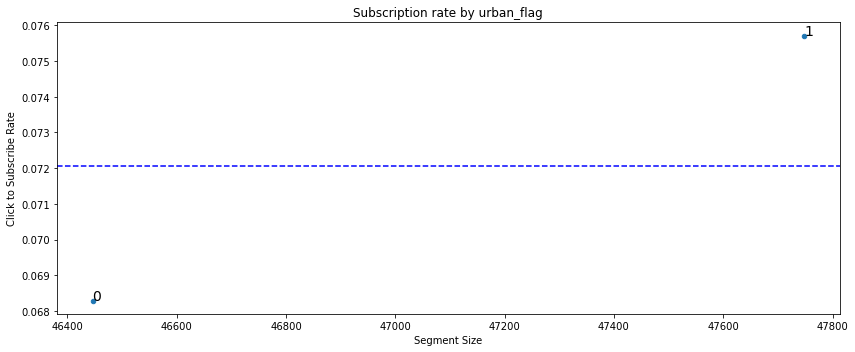

In [21]:
plot_subscription_rate_by_var(df, "urban_flag")

### Credit Card on File
* Clicks where the person has a credit card on file (existing users) subscribe at much higher rates

In [22]:
calc_chi_2_test(df, "credit_card_on_file")

The p-value is 0.0
The result is significant at the 95% confidence level. The variable credit_card_on_file influences subscriber rates


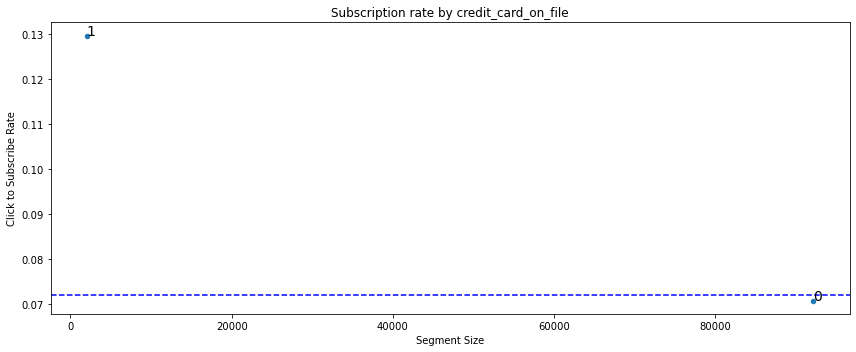

In [23]:
plot_subscription_rate_by_var(df, "credit_card_on_file")

### Student
* Non-students subscribe at somewhat higher rates than students, but the difference is not statistically significant

In [24]:
calc_chi_2_test(df, "student")

The p-value is 0.0337
The result is significant at the 95% confidence level. The variable student influences subscriber rates


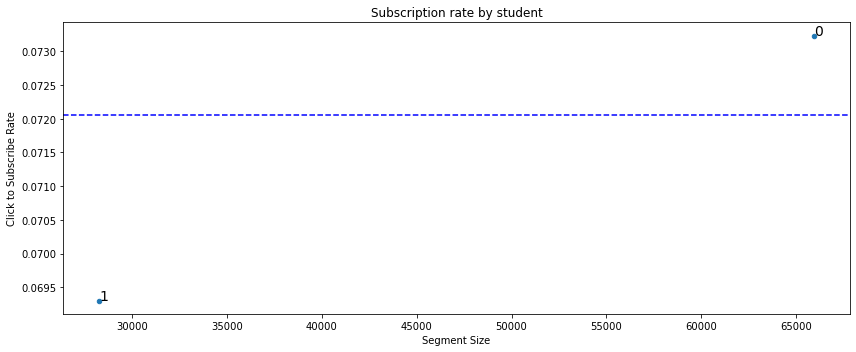

In [25]:
plot_subscription_rate_by_var(df, "student")

### Favorite genre
* Users without known favorite genres responded to the ad at a higher than average rate
* Techno users, with few total clicks, subscribed at average rates, possibly worth increased targeting
* All other favorite genre clicks performed below baseline, suggesting the ad was not relevant to the user

In [26]:
df.groupby("fav_genre").agg({"subscriber":["mean", "count"]}).reset_index()

fav_genre subscriber       
                    mean  count
0     Unknown   0.086216   9859
1   classical   0.052478    343
2     country   0.046154    195
3     hip_hop   0.072501  77971
4  indie_rock   0.036107   1911
5       latin   0.037699   2069
6   punk_rock   0.054180    646
7         r&b   0.058518    769
8      techno   0.069606    431

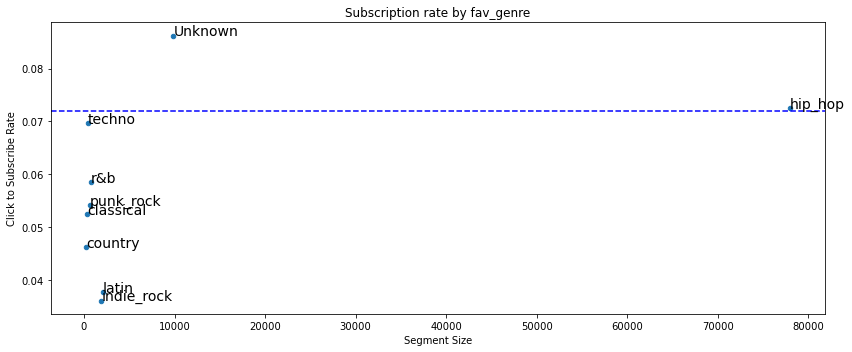

In [27]:
plot_subscription_rate_by_var(df, "fav_genre")

### Holidays
* The ad performed significantly below baseline on Holidays (Christmas, New Years).
* Be wary of drawing conclusions from holiday periods. User behavior does change for the holidays

In [28]:
calc_chi_2_test(df_clean, "is_holiday")

The p-value is 0.0469
The result is significant at the 95% confidence level. The variable is_holiday influences subscriber rates


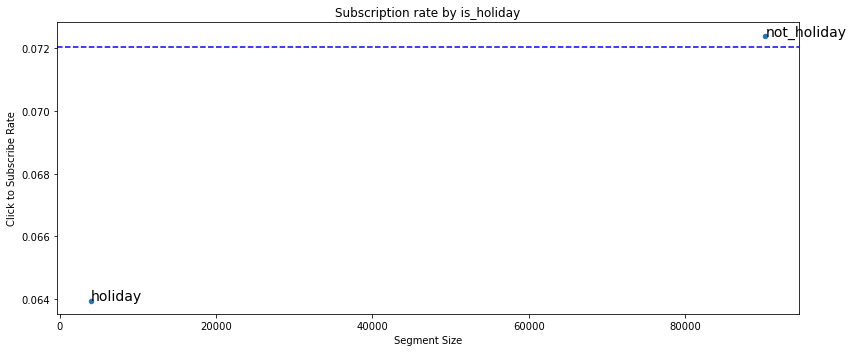

In [29]:
plot_subscription_rate_by_var(df_clean, "is_holiday")

# Model Setup

After viewing each variable's interactions with subscribe rate, let's build a model to predict subscription rate for a new click. The outcome variable is binary (did the click lead to a subscription or not) and model insights are more valuable than model performance.

The ML model used is a random forest. I selected a random forest for 2 reasons:
* It requires little hyperparameter optimization for good results. The default parameters usually give a near-optimal model.
* Tree based models work well with both continuous, categorical, and binary variables. They also handle outliers and missing values well.

The random forest model is used to predict a likelihood of subscription, and then variable importance and partial dependence plots are used to gather insights.


# Model Performance
The model achieves an out of sample AUC score of 0.58, indicating that it is somewhat predictive of subscription_rate. A model with an AUC of 0.5 is random, and a model with an AUC of 1 is a perfect score. Based on the limited user data available, a model with an AUC of 0.58 would be considered acceptable.

Model Performance metrics:
------------------------------
Log Loss: 0.4459
Accuracy: 0.928
Precision: 0.8766
Recall: 0.928
F1 Score: 0.896

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.17      0.01      0.01      1321
           0       0.93      1.00      0.96     17518

    accuracy                           0.93     18839
   macro avg       0.55      0.50      0.49     18839
weighted avg       0.88      0.93      0.90     18839


Prediction Confusion Matrix:
------------------------------
          Predicted:       
                   1      0
Actual: 1          9   1312
        0         45  17473
The AUC Value is 0.59


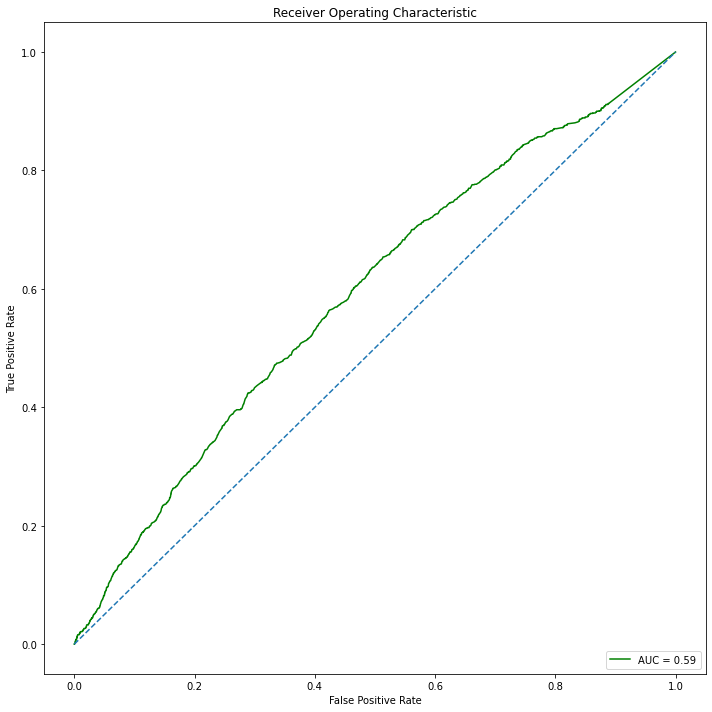

In [30]:
clf, x_train, y_train = run_fit_evaluate_model(base_folder, "rf_all_vars", save_external=True)

# Model Insights

## Variable Importance
The variable importance plot displays a similar story to the plots above. 

The most important variables are related to day of week, urban status, student status, holidays, credit card status, and some of the cities

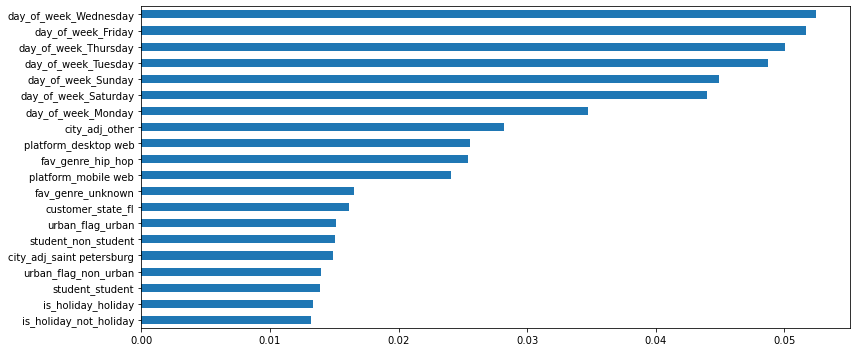

In [31]:
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.sort_values()[-20:].plot(kind='barh', figsize=(12, 5));

## Partial Dependence Plots

Partial dependence plots isolate the effect of a single variable for the model's predictions. Because variables may be correlated in the single dimensional descriptive analyses, the ML model can isolate each variable's contribution.

### Day of Week
* Clicks on the ad are more likely to subscribe on a weekend and are far less likely to subscribe on a Monday

day_of_week_Friday       0.073813
day_of_week_Monday       0.064159
day_of_week_Saturday     0.073626
day_of_week_Sunday       0.074993
day_of_week_Thursday     0.071993
day_of_week_Tuesday      0.072959
day_of_week_Wednesday    0.074765
day_of_week_nan          0.072046
dtype: float64

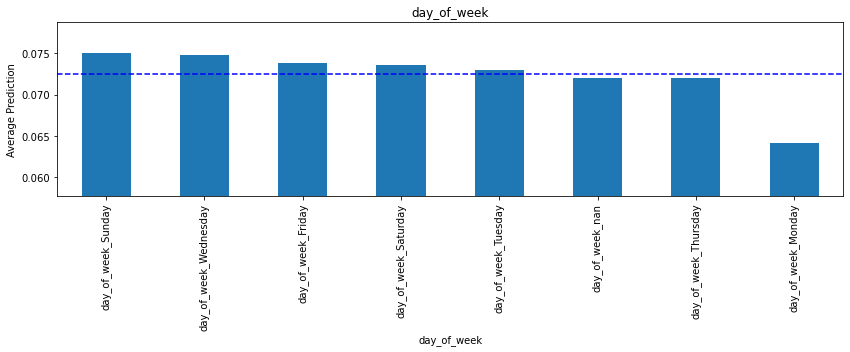

In [32]:
plot_partial_dependence(clf, x_train, y_train, "day_of_week")

### Customer City
A few cities perform better than their initial performance would suggest. Honolulu and Miami beach were heavily targeted and performed well. 

Other cities to consider for future ad campaigns in the future would include Newark, Tempe, Saint Paul, Detroit.

As shown in the descriptive statistics, St. Louis, Orlando, and West Park performed noticably poorly, even after adjusting for other factors.

NOTE: Huge difference between actual and model predicted performance for St. Petersburg!! This is because St. Petersburg clicks stopped halfway through on 12/29

city_adj_atlanta             0.079257
city_adj_austin              0.070785
city_adj_baltimore           0.071175
city_adj_boston              0.079168
city_adj_charlotte           0.074792
city_adj_chicago             0.075549
city_adj_colorado springs    0.067398
city_adj_dallas              0.068685
city_adj_day                 0.070702
city_adj_denver              0.083280
city_adj_detroit             0.085911
city_adj_fort lauderdale     0.075771
city_adj_hoboken             0.076649
city_adj_honolulu            0.097287
city_adj_houston             0.073127
city_adj_kahului             0.073332
city_adj_kailua kona         0.061827
city_adj_las vegas           0.074946
city_adj_lihue               0.073849
city_adj_los angeles         0.076932
city_adj_miami               0.073928
city_adj_miami beach         0.087615
city_adj_minneapolis         0.072947
city_adj_nashville           0.080613
city_adj_newark              0.079877
city_adj_north miami         0.081942
city_adj_ont

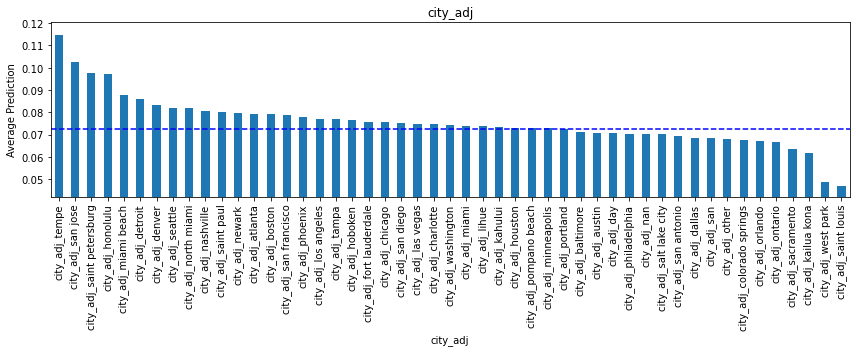

In [33]:
plot_partial_dependence(clf, x_train, y_train, "city_adj")

### Favorite Genre
After accounting for all other features, the relative effect of "fav_genre = classical" is slightly positive.
Indie rock, latin, and punk rock listeners are negative influences on subscription rate for this ad, and should be avoided as much as possible.

fav_genre_classical     0.066472
fav_genre_country       0.056797
fav_genre_hip_hop       0.071429
fav_genre_indie_rock    0.048699
fav_genre_latin         0.055078
fav_genre_punk_rock     0.065757
fav_genre_r&b           0.058984
fav_genre_techno        0.064656
fav_genre_unknown       0.078004
fav_genre_nan           0.062085
dtype: float64

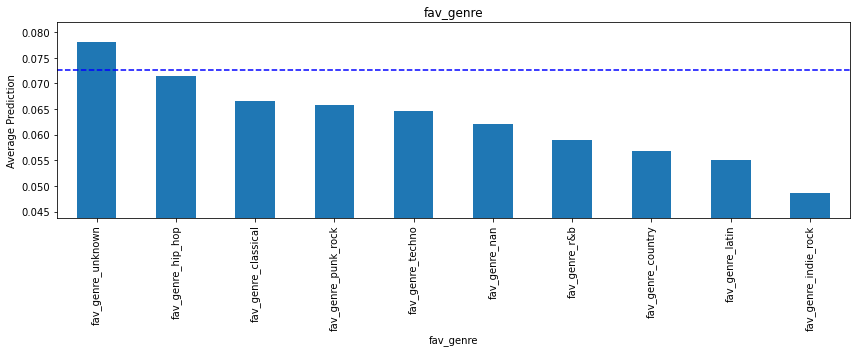

In [34]:
plot_partial_dependence(clf, x_train, y_train, "fav_genre")

### Platform
Even after accounting for all other effects, desktop clicks perform better than mobile clicks. MicDrop should fix any user facing bugs (possibly by device, tablet vs phone) for mobile

platform_desktop web           0.082854
platform_mobile web            0.066586
platform_undefined platform    0.073437
platform_nan                   0.073630
dtype: float64

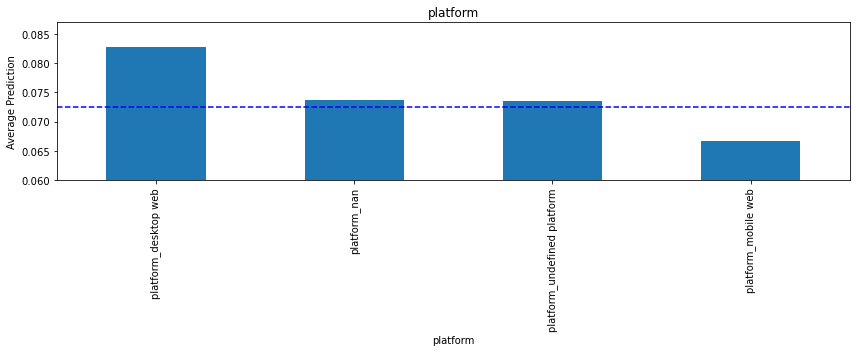

In [35]:
plot_partial_dependence(clf, x_train, y_train, "platform")

### Student
The subscription rate for students performs better than that of non-students. This is counter-intuitive because the overall rates for both groups was flipped. This relationship indicates that the "poor" performance of the student demographic was a result of other correlated factors.


In addition, contacting students during the holiday break is a poor advertising decision. Students are often at their parents' / other family member's home during the holiday break. Therefore, geographic based targeting will perform below average during this time period.

student_non_student    0.075877
student_student        0.076249
student_nan            0.075934
dtype: float64

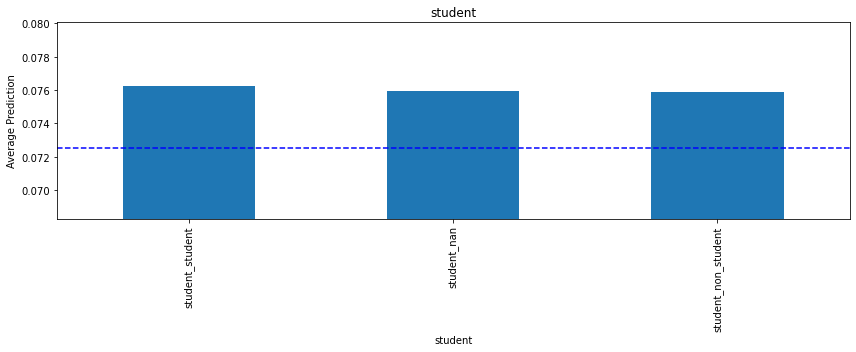

In [36]:
plot_partial_dependence(clf, x_train, y_train, "student")

### Credit Card (Existing Customer)

Existing customers subscribe at significantly higher rates than new customers. Keep contacting them as much as possible!

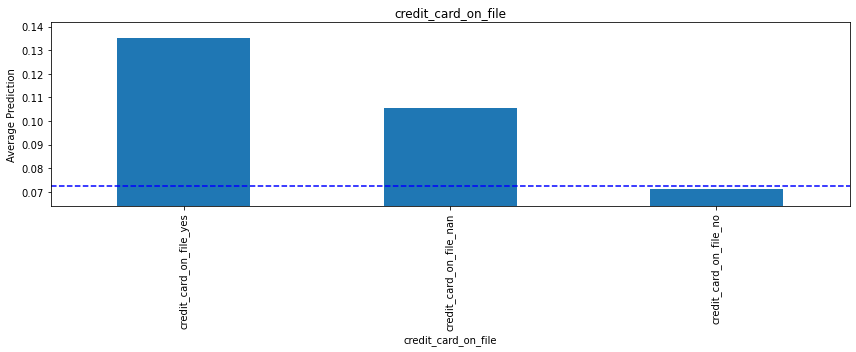

In [37]:
df = plot_partial_dependence(clf, x_train, y_train, "credit_card_on_file")

### Urban

After controlling for extraneous factors, urban clicks perform above baseline, and non-urban clicks perform below baseline. This may be explained by students who live in urban environments migrating to their parent's / family member's homes in the suburbs for the holidays.

urban_flag_non_urban    0.069803
urban_flag_urban        0.079508
urban_flag_nan          0.074233
dtype: float64

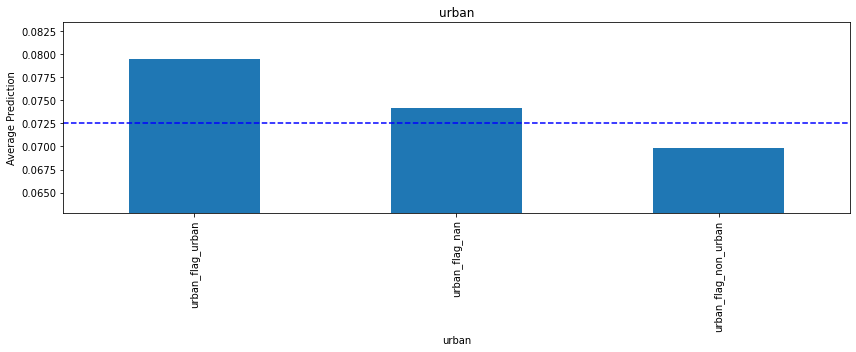

In [39]:
plot_partial_dependence(clf, x_train, y_train, "urban")

### Holiday

The ads perform worse on holidays (even after accounting for other factors) than on non-holidays. This ad campaign may benefit from being run for another week or two, to compensate for the holiday period.

is_holiday_holiday        0.071676
is_holiday_not_holiday    0.072313
is_holiday_nan            0.072255
dtype: float64

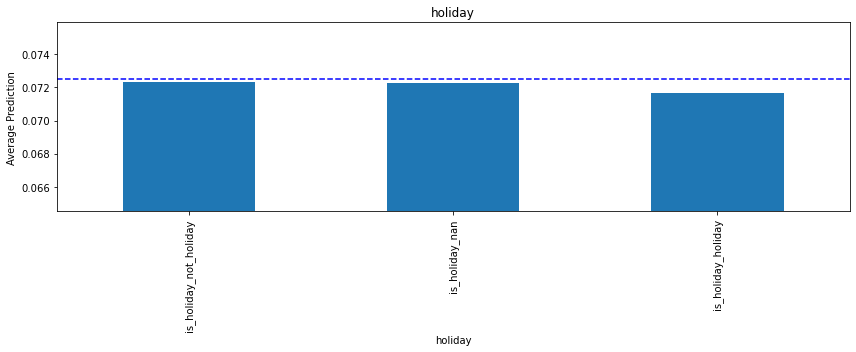

In [40]:
plot_partial_dependence(clf, x_train, y_train, "holiday")

# Future Improvements

To improve the performance of the click-to-subscribe likelihood model, I would augment the training data with additional variables:

* ip_address_location -> Due to the holiday period, many customers may be accessing the ad in a location that is not their home area
* customer_zipcode -> Would be useful to join this field to location data (average incomes, average family demographics, etc.)
* Metro area -> To group cities and their suburbs together (ex: Saint Petersburg and Tampa, Miami and North Miami)
* For customers who subscribe, validate the data quality of the 3rd party "fav_genre" field with the user's listening perferences

# Key Insights

* The ad appears to be a **hip-hop focused** ad that **targeted students** in **select metro areas**
* **Existing customers** subscribe at much higher rates than new customers. Create targeted content for existing customer base
* The desktop banners out performs the mobile banner. MicDrop should seek to **optimize the mobile experience** for its targeted advertising.
* The ad's **performance differs significantly by city**. MicDrop should continue to display similar content in Honolulu and Miami, increase it's targeting presence for the same ad in Newark and Detroit, and stop displaying this ad in St. Louis and Orlando. 
* The **holiday period** is a large **confounding factor** in measuring ad performance. The "student segment" displays significantly different behavior during the semester versus during breaks.